In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import koreanize_matplotlib

warnings.filterwarnings('ignore')

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [6]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
submit = pd.read_csv("./sample_submission.csv")

In [14]:
train

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36,6,RENT,72000000.0,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60,10,MORTGAGE,130800000.0,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36,5,MORTGAGE,96000000.0,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36,8,MORTGAGE,132000000.0,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60,11,RENT,71736000.0,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,TRAIN_96289,14400000,36,10,MORTGAGE,210000000.0,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,TRAIN_96290,28800000,60,10,MORTGAGE,132000000.0,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,TRAIN_96291,14400000,36,1,MORTGAGE,84000000.0,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,TRAIN_96292,15600000,36,5,MORTGAGE,66330000.0,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


In [7]:
# 근로기간 전처리
train["근로기간"] = train["근로기간"].str.replace("years", "").str.replace("year", "")
train["근로기간"] = train["근로기간"].str.replace(" ", "")
train["근로기간"] = train["근로기간"].str.replace("10+", "10")
train["근로기간"] = train["근로기간"].str.replace("<1", "0")
train["근로기간"] = train["근로기간"].str.replace("Unknown", "11")
train["근로기간"] = train["근로기간"].astype(int)

test["근로기간"] = test["근로기간"].str.replace("years", "").str.replace("year", "")
test["근로기간"] = test["근로기간"].str.replace(" ", "")
test["근로기간"] = test["근로기간"].str.replace("10+", "10")
test["근로기간"] = test["근로기간"].str.replace("<1", "0")
test["근로기간"] = test["근로기간"].str.replace("Unknown", "11")
test["근로기간"] = test["근로기간"].astype(int)

# 대출기간 전처리
train["대출기간"] = train["대출기간"].str.replace(" months", "").astype(int)
test["대출기간"] = test["대출기간"].str.replace(" months", "").astype(int)

In [8]:
# 연간소득이 0인 값이 있어서 대체
index_to_train1 = train[train["연간소득"] == 0].index
index_to_test1 = test[test["연간소득"] == 0].index

for index in index_to_train1:
    train.loc[index, "연간소득"] = train.loc[index, "대출금액"] / (train.loc[index, "부채_대비_소득_비율"] / 100)

for index in index_to_test1:
    test.loc[index, "연간소득"] = test.loc[index, "대출금액"] / (test.loc[index, "부채_대비_소득_비율"] / 100)

In [48]:
train["연간소득"]

0         72000000.0
1        130800000.0
2         96000000.0
3        132000000.0
4         71736000.0
            ...     
96289    210000000.0
96290    132000000.0
96291     84000000.0
96292     66330000.0
96293     50400000.0
Name: 연간소득, Length: 96294, dtype: float64

In [15]:
# train 특성엔지니어링
train["월_대출금액"] = round(train["대출금액"] / train["대출기간"],1)
train["월_대출대비_소득비율"] = round((train["연간소득"]/12)/train["월_대출금액"],1)

train["계좌수"] = train["총계좌수"] / (train["연체계좌수"] + 1)

train["대출금액_총상환이자_비율"] = np.where(train["총상환이자"] == 0, np.nan, train["대출금액"] / train["총상환이자"])
train["대출금액_총상환이자_비율"].fillna(0, inplace=True)

train["대출금액_총상환원금_비율"] = np.where(train["총상환원금"] == 0, np.nan, train["대출금액"] / train["총상환원금"])
train["대출금액_총상환원금_비율"].fillna(0, inplace=True)

train["상환이자_상환원금"] = train.apply(lambda x : 0 if x["총상환이자"] == x["총상환원금"] else (1 if x["총상환이자"] > x["총상환원금"] else 2), axis=1)

train["최근_2년간_연체_횟수"] = train["최근_2년간_연체_횟수"].apply(lambda x: 1 if x > 0 else 0)

train["총상환액"] = train["총상환원금"] + train["총상환이자"]

train["소득대비_총상환액_비율"] = train["총상환액"] / train["연간소득"]
train["대출대비_총상환액_비율"] = train["총상환액"] / train["대출금액"]
train["기간대비_총상환액_비율"] = train["총상환액"] / train["대출기간"]

train["대출대비_총상환원금_비율"] = train["총상환원금"] / train["대출금액"]
train["대출대비_총상환이자_비율"] = train["총상환이자"] / train["대출금액"]

train["소득대비_총상환원금_비율"] = train["총상환원금"] / train["연간소득"]
train["소득대비_총상환이자_비율"] = train["총상환이자"] / train["연간소득"]

train["기간대비_총상환원금_비율"] = train["총상환원금"] / train["대출기간"]
train["기간대비_총상환이자_비율"] = train["총상환이자"] / train["대출기간"]

train["월_이자_지불액"] = train["대출금액"] * train["대출금액_총상환이자_비율"] / train["대출기간"]

# -------------------------------------------------------------------------------------------------------------------------------------------------
# test 특성엔지니어링
test["월_대출금액"] = round(test["대출금액"] / test["대출기간"],1)
test["월_대출대비_소득비율"] = round((test["연간소득"]/12)/test["월_대출금액"],1)

test["계좌수"] = test["총계좌수"] / (test["연체계좌수"] + 1)

test["대출금액_총상환이자_비율"] = np.where(test["총상환이자"] == 0, np.nan, test["대출금액"] / test["총상환이자"])
test["대출금액_총상환이자_비율"].fillna(0, inplace=True)

test["대출금액_총상환원금_비율"] = np.where(test["총상환원금"] == 0, np.nan, test["대출금액"] / test["총상환원금"])
test["대출금액_총상환원금_비율"].fillna(0, inplace=True)

test["상환이자_상환원금"] = test.apply(lambda x : 0 if x["총상환이자"] == x["총상환원금"] else (1 if x["총상환이자"] > x["총상환원금"] else 2), axis=1)

test["최근_2년간_연체_횟수"] = test["최근_2년간_연체_횟수"].apply(lambda x: 1 if x > 0 else 0)

test["총상환액"] = test["총상환원금"] + test["총상환이자"]

test["소득대비_총상환액_비율"] = test["총상환액"] / test["연간소득"]
test["대출대비_총상환액_비율"] = test["총상환액"] / test["대출금액"]
test["기간대비_총상환액_비율"] = test["총상환액"] / test["대출기간"]

test["대출대비_총상환원금_비율"] = test["총상환원금"] / test["대출금액"]
test["대출대비_총상환이자_비율"] = test["총상환이자"] / test["대출금액"]

test["소득대비_총상환원금_비율"] = test["총상환원금"] / test["연간소득"]
test["소득대비_총상환이자_비율"] = test["총상환이자"] / test["연간소득"]

test["기간대비_총상환원금_비율"] = test["총상환원금"] / test["대출기간"]
test["기간대비_총상환이자_비율"] = test["총상환이자"] / test["대출기간"]

test["월_이자_지불액"] = test["대출금액"] * test["대출금액_총상환이자_비율"] / test["대출기간"]

In [16]:
# 필요없거나 많이 사용한 속성 삭제
train.drop(["총계좌수", "총상환원금", "총상환이자", "연체계좌수", "총연체금액"], axis=1, inplace=True)
test.drop(["총계좌수", "총상환원금", "총상환이자","연체계좌수", "총연체금액"], axis=1, inplace=True)

In [23]:
# 바이너리 인코딩
import category_encoders as ce

train_ex = train.copy()
test_ex = test.copy()

# Creating a BinaryEncoder instances
encoder = ce.BinaryEncoder(cols=['대출목적'])

# Fitting and transforming the 'occupation' column
train_encoded = encoder.fit_transform(train_ex['대출목적'])
test_encoded = encoder.transform(test_ex['대출목적'])

encoded_train_columns = train_encoded.columns
encoded_test_columns = test_encoded.columns

# Creating a DataFrame from the binary encoded data
train_encoded_df = pd.DataFrame(train_encoded, columns=encoded_train_columns)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_test_columns)
train = pd.concat([train, train_encoded_df], axis=1).drop(['대출목적'], axis=1)
test = pd.concat([test, test_encoded_df], axis=1).drop(['대출목적'], axis=1)

In [24]:
# 라벨 인코딩 수동판
# 정의하지 않은 값에 대해서는 NaN으로 변경 -> 3으로 변경(ex ANY)
# map으로 바꾸니까 float으로 되서.. int로 바꿔줌

replacement2_dict = {"RENT":0, "MORTGAGE":1, "OWN":2}

train["주택소유상태"] = train["주택소유상태"].map(replacement2_dict).fillna(3).astype(int)
test["주택소유상태"] = test["주택소유상태"].map(replacement2_dict).fillna(3).astype(int)

In [25]:
train_x = train.drop(["ID", "대출등급"], axis=1)
train_y = train["대출등급"]

test_x = test.drop(["ID"], axis=1)

In [26]:
from sklearn.preprocessing import StandardScaler

# 표준화를 위한 scaler 객체 생성 및 훈련 데이터에 적용
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_x)

# 테스트 데이터에 훈련 데이터의 평균과 표준편차를 적용하여 표준화
test_scaled = scaler.transform(test_x)

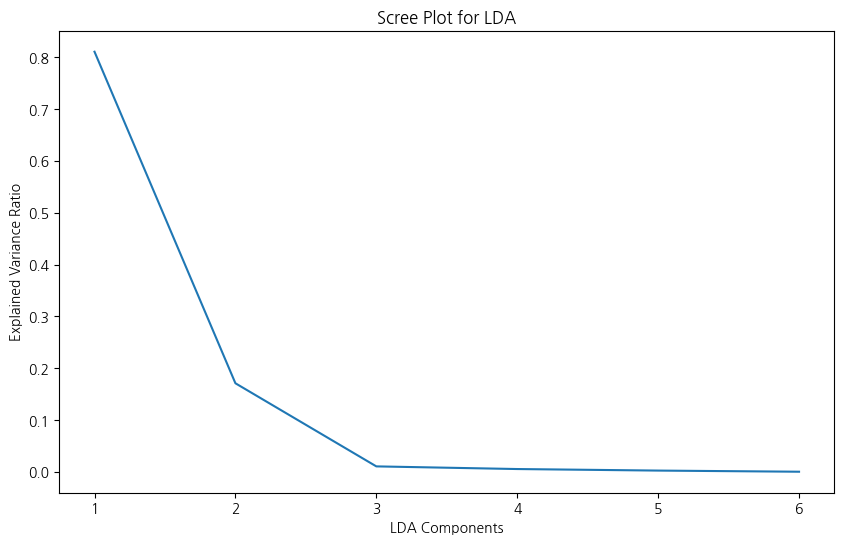

In [27]:
# LDA 객체 생성
lda = LDA()

# LDA를 훈련 데이터에 적용
lda.fit(train_scaled, train_y)
lda_transformed_train = lda.transform(train_scaled)

plt.figure(figsize=(10, 6))
plt.plot(range(1, lda_transformed_train.shape[1] + 1), lda.explained_variance_ratio_)
plt.xlabel('LDA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot for LDA')
plt.show()

In [28]:
# LDA수는 가장 적합한 2로 설정해서 다시 적용
lda = LDA(n_components=2)

lda.fit(train_scaled, train_y)
lda_transformed_train = lda.transform(train_scaled)

lda_transformed_test = lda.transform(test_scaled)

In [30]:
lda_transformed_train.shape[1]

2

In [31]:
# LDA로 생성된 칼럼명을 작성하기 위함
lda_columns_train = [f'LDA{i+1}' for i in range(lda_transformed_train.shape[1])]
lda_columns_test = [f'LDA{i+1}' for i in range(lda_transformed_test.shape[1])]

lda_df_train = pd.DataFrame(lda_transformed_train, columns = lda_columns_train)
lda_df_test = pd.DataFrame(lda_transformed_test, columns = lda_columns_test)

In [37]:
# NumPy 배열을 데이터프레임으로 변환
scaled_train = pd.DataFrame(train_scaled, columns=train_x.columns, index=train_x.index)
scaled_test = pd.DataFrame(test_scaled, columns=test_x.columns, index=test_x.index)

In [39]:
lda_train_x = pd.concat([scaled_train, lda_df_train], axis=1)
lda_test_x = pd.concat([scaled_test, lda_df_test], axis=1)

In [41]:
lda_train_x.columns

Index(['대출금액', '대출기간', '근로기간', '주택소유상태', '연간소득', '부채_대비_소득_비율', '최근_2년간_연체_횟수',
       '월_대출금액', '월_대출대비_소득비율', '계좌수', '대출금액_총상환이자_비율', '대출금액_총상환원금_비율',
       '상환이자_상환원금', '총상환액', '소득대비_총상환액_비율', '대출대비_총상환액_비율', '기간대비_총상환액_비율',
       '대출대비_총상환원금_비율', '대출대비_총상환이자_비율', '소득대비_총상환원금_비율', '소득대비_총상환이자_비율',
       '기간대비_총상환원금_비율', '기간대비_총상환이자_비율', '월_이자_지불액', '대출목적_0', '대출목적_1',
       '대출목적_2', '대출목적_3', 'LDA1', 'LDA2'],
      dtype='object')

In [58]:
import xgboost as xgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# LabelEncoder를 사용하여 문자열 클래스를 정수로 변환
label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)

X_train, X_test, y_train, y_test = train_test_split(lda_train_x, train_y_encoded, test_size=0.2, random_state=42)


# XGBoost 모델 초기화 및 학습
model = xgb.XGBClassifier(
    learning_rate=0.1,  # 학습률
    n_estimators=100,  # 트리의 개수
    max_depth=3,       # 트리의 최대 깊이
    subsample=0.8,     # 각 트리에 사용할 훈련 데이터의 비율
    colsample_bytree=0.8,  # 각 트리에 사용할 특성의 비율
    gamma=0.1,         # 트리의 가지치기에 사용되는 최소 손실 감소 값
    random_state=42
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [59]:
# 테스트 세트에 대한 예측 수행
y_pred = model.predict(lda_test_x)

In [60]:
# 예측 결과를 다시 문자열 형태로 디코딩
y_pred_original = label_encoder.inverse_transform(y_pred)

In [63]:
submit['대출등급'] =y_pred_original
submit

,ID,대출등급
0,TEST_00000,B
1,TEST_00001,B
2,TEST_00002,A
3,TEST_00003,C
4,TEST_00004,C
...,...,...
64192,TEST_64192,D
64193,TEST_64193,D
64194,TEST_64194,D
64195,TEST_64195,C


In [64]:
submit.to_csv('xgboost1.csv', index=False)